In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM  # I use keras over Tensorflow 2, so I don't need extra Keras libraries.
from tensorflow.keras.models import Sequential  # Tensorflow includes Keras libraries after 2nd version of Tensorflow
from sklearn.preprocessing import MinMaxScaler  # If you have Tensorflow 1, please upgrade your library using:
                                                # conda install tensorflow
                                                # This command will upgrade your Tensorflow module to the latest version.

In [243]:
df = pd.read_csv('prices-split-adjusted.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [244]:
type(df)


pandas.core.frame.DataFrame

In [245]:
df.duplicated().sum()


0

In [246]:
df.isna().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [247]:
# Scalling
KSU_df= df[df['symbol'] == 'KSU']
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
KSU_df.drop(['symbol'], axis=1, inplace=True)
x = KSU_df[['open', 'low', 'high', 'volume']].copy()
y = KSU_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))


<ipython-input-247-851c468ada32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KSU_df.drop(['symbol'], axis=1, inplace=True)


In [248]:
def get_data(data, steps):      
    dataX = []
    dataY = []
    for i in range(len(data)-steps-1):
        a = data[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(data[i+steps, 0])
    return np.array(dataX), np.array(dataY)

In [249]:
steps = 20


In [250]:
x['close'] = y
train = x.iloc[0:1700,:].values
test = x.iloc[1700:,:].values

In [252]:
X_train, y_train = get_data(train, steps)
X_test, y_test = get_data(test, steps)

In [257]:
# Im reshaping my sets for using in LSTM model..
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [258]:
# I will use a Sequential model with 2 hidden layers
# Instead of neurons, LSTM networks have memory blocks that are connected through layers.
# The default sigmoid activation function is used for the LSTM blocks. 

model = Sequential()
model.add(LSTM(128, input_shape = (1, steps)))  # This is my first hidden layer with 128 memory blocks
model.add(Dense(64))                                  # This is my second hidden layer with 64 memory blocks
model.add(Dense(1))   # This is my output layer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [259]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               76288     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 84,609
Trainable params: 84,609
Non-trainable params: 0
_________________________________________________________________


In [260]:
model.fit(X_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
1679/1679 [==============================] - 5s 2ms/step - loss: 0.0026
Epoch 2/25
1679/1679 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 3/25
1679/1679 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 4/25
1679/1679 [==============================] - 4s 2ms/step - loss: 9.1447e-04
Epoch 5/25
1679/1679 [==============================] - 4s 2ms/step - loss: 8.5363e-04
Epoch 6/25
1679/1679 [==============================] - 4s 2ms/step - loss: 8.0218e-04
Epoch 7/25
1679/1679 [==============================] - 4s 2ms/step - loss: 8.1522e-04
Epoch 8/25
1679/1679 [==============================] - 4s 2ms/step - loss: 7.8030e-04
Epoch 9/25
1679/1679 [==============================] - 4s 2ms/step - loss: 7.5278e-04
Epoch 10/25
1679/1679 [==============================] - 4s 2ms/step - loss: 6.7795e-04
Epoch 11/25
1679/1679 [==============================] - 4s 2ms/step - loss: 6.7551e-04
Epoch 12/25
1679/1679 [==============================

### Let's make prediction..

In [261]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 3ms/step


In [263]:
y_scaler=MinMaxScaler()

y_scaler.fit(y_pred)

y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_test.reshape(-1, 1)
y_test = y_scaler.inverse_transform(y_test)

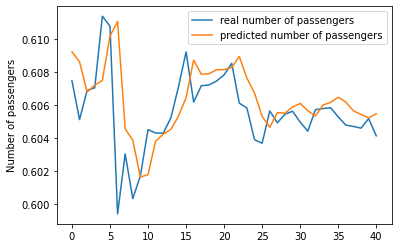

In [264]:
# plot real number of passengers and predictions...
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('Months')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()